### Loading Data + Seeding

In [1]:
import tarfile
!wget -q --show-progress https://github.com/ShenLab/PreMode/raw/main/data.files/GCK.tgz
!wget -q --show-progress https://github.com/ShenLab/PreMode/raw/main/data.files/ASPA.tgz
!wget -q --show-progress https://github.com/ShenLab/PreMode/raw/main/data.files/PTEN.tgz
!wget -q --show-progress https://github.com/ShenLab/PreMode/raw/main/data.files/CCR5.tgz

files = ["PTEN.tgz", "GCK.tgz", "ASPA.tgz", "CCR5.tgz"]

for file in files:
    with tarfile.open(file, 'r:gz') as tar:
        tar.extractall()

GCK.tgz             100%[===================>]   9.49M  --.-KB/s    in 0.04s   
ASPA.tgz            100%[===================>]   6.20M  --.-KB/s    in 0.04s   
PTEN.tgz            100%[===================>]   4.05M  --.-KB/s    in 0.02s   
CCR5.tgz            100%[===================>]   5.52M  --.-KB/s    in 0.04s   


In [2]:
import pandas as pd
import os

for protein in [protein[:-4] for protein in files]:
    for filename in os.listdir(protein):
        if filename.endswith("annotated.csv"):
            df = pd.read_csv(f"{protein}/{filename}")
            print(f"{protein} n mutations: {df.shape}")

PTEN n mutations: (3927, 69)
GCK n mutations: (8255, 74)
ASPA n mutations: (5840, 72)
CCR5 n mutations: (6545, 69)


In [3]:
import torch
import numpy as np
import random

# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)


### Defining the model

In [5]:
!pip install fair-esm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 4.8 MB/s eta 0:00:00


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import esm
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import Subset, DataLoader

class ESMGain(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super().__init__()

        freeze_up_to = 10

        self.esm2mut, _ = esm.pretrained.esm2_t12_35M_UR50D()    # alternatively: esm2_t30_150M_UR50D
        for i in range(freeze_up_to):
            for param in self.esm2mut.layers[i].parameters():
                param.requires_grad = False

        self.esm2wt, _ = esm.pretrained.esm2_t12_35M_UR50D()
        for i in range(freeze_up_to):
            for param in self.esm2wt.layers[i].parameters():
                param.requires_grad = False

        embedding_dim = 480 # 640 for 150M model
        self.n_layers = 12

        # Regression head
        self.const1 = torch.nn.Parameter(torch.ones((1,embedding_dim)))
        self.const2 = torch.nn.Parameter(-1 * torch.ones((1,embedding_dim)))
        self.const3 = torch.nn.Parameter(torch.ones((1,embedding_dim)))
        self.const4 = torch.nn.Parameter(-1 * torch.ones((1,embedding_dim)))

        self.dropout = nn.Dropout(dropout_rate)
        self.classifierbig = nn.Linear(2*embedding_dim, embedding_dim)
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(embedding_dim, 1)

    def forward(self, token_ids1, token_ids2, pos, lengths):

        batch_size = token_ids1.shape[0]

        mut = self.esm2mut(token_ids2, repr_layers=[self.n_layers])['representations'][self.n_layers]
        wt = self.esm2wt(token_ids1, repr_layers=[self.n_layers])['representations'][self.n_layers]

        x = []
        for i in range(batch_size):

            position = self.const1 * wt[i, pos[i], :] + self.const2 * mut[i, pos[i], :]
            mean = self.const3 * wt[i, 1:lengths[i]+1].mean(dim=0) + self.const4 * mut[i, 1:lengths[i]+1].mean(dim=0)

            x.append(torch.concat((position, mean), dim=1))    # stacks behind -> shape 2*embedding_dim

        x = torch.stack(x).squeeze(1)  # (batch_size, 2*embedding_dim)
        x = self.dropout(self.relu(self.classifierbig(self.dropout(x))))  # (batch_size, 1*embedding_dim)
        predictions = self.classifier(x)  # (batch_size, 3)

        return predictions


def setup_optimizer_and_scheduler(model, train_loader, epochs, lr_for_esm, lr_for_head):

    # Define learning rates
    lr_esm =  batch_size * lr_for_esm  # Lower learning rate for pre-trained ESM2 layers
    lr_new =  batch_size * lr_for_head  # Higher learning rate for new layers (classifier)

    # Group parameters
    esm_params = list(model.esm2mut.parameters()) + list(model.esm2wt.parameters()) #<- those are frozen
    new_params = (
        [model.const1] + [model.const2] + [model.const3] + [model.const4] +
        list(model.classifierbig.parameters()) + list(model.classifier.parameters())
    )

    # Create parameter groups with different learning rates
    param_groups = [
        {'params': esm_params, 'lr': lr_esm},
        {'params': new_params, 'lr': lr_new}
    ]

    # Initialize the optimizer with parameter groups
    optimizer = AdamW(param_groups, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)   # defaults: , betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01
                                # for ESM2 pretraining: weightβ1 = 0. 9, β2 = 0. 98, ϵ = 10−8 𝐿2 weight decay of 0.01

    # Create the scheduler
    scheduler = OneCycleLR(
        optimizer,
        max_lr=[lr_esm, lr_new],  # Specify max_lr for each group
        steps_per_epoch=len(train_loader),
        epochs=epochs,
    )
    return optimizer, scheduler

In [7]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split

class ProteinDataset(Dataset):
    def __init__(self, df):
        self.df = df
        _, esm1v_alphabet = esm.pretrained.esm2_t12_35M_UR50D()
        self.esm1v_batch_converter = esm1v_alphabet.get_batch_converter()

    def __getitem__(self, idx):
        _, _, esm1b_batch_tokens1 = self.esm1v_batch_converter([('' , ''.join(self.df.iloc[idx]['wt_seq'])[:1022])])
        _, _, esm1b_batch_tokens2 = self.esm1v_batch_converter([('' , ''.join(self.df.iloc[idx]['mut_seq'])[:1022])])
        pos = self.df.iloc[idx]['pos']
        length = len(self.df.iloc[idx]["wt_seq"])
        score = torch.tensor(self.df.iloc[idx]["score"], dtype=torch.float)
        return esm1b_batch_tokens1, esm1b_batch_tokens2, pos, length, torch.unsqueeze(torch.FloatTensor([self.df.iloc[idx]['score']]), 0)     # hat shape 1, 1 wegen unsqueeze, sonst shape 1, ohne eckige klammer size 0

    def __len__(self):
        return len(self.df)


def collate_fn(batch):
    esm1b_batch_tokens1, esm1b_batch_tokens2, pos, length, labels = zip(*batch)

    esm1b_batch_tokens1 = pad_sequence([tokens[0].clone().detach() for tokens in esm1b_batch_tokens1], batch_first=True, padding_value=1)
    esm1b_batch_tokens2 = pad_sequence([tokens[0].clone().detach() for tokens in esm1b_batch_tokens2], batch_first=True, padding_value=1)


    pos = torch.tensor(pos, dtype=torch.long)
    length = torch.tensor(length, dtype=torch.long)
    labels = torch.stack(labels)

    return esm1b_batch_tokens1, esm1b_batch_tokens2, pos, length, labels


def plot_with_rolling_average(losses, window_size):
  losses_series = pd.Series(losses)
  rolling_average = losses_series.rolling(window=window_size).mean()

  plt.scatter([i for i in range(len(losses))], losses, color="red", alpha=0.1)
  plt.plot(rolling_average, color="blue", label=f"Rolling Average (Window: {window_size})")
  plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Training on DMS

defining train function (incl. small eval function)

In [11]:
from scipy.stats import pearsonr, spearmanr
import scipy.stats as stats
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import math
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt

losses = []  # stores every loss == globalbatchlosses when doing with accumul_steps=1
globalbatchlosses = []  # useful when doing grad accumulation, want to only plot the average loss of the batch, not every single sub/mini-batch
globalbatchlossescache = []  # for every global batch (with grad accumul) stores the intermediate losses, gets resetted after each global batch


scaler = torch.amp.GradScaler(device='cuda')


def traingradaccumulation(epoch, training_loader, test_loader, eval_training_loader, scaler, accumulation_steps, evaluate_training_set=True, verbose=False):
    global globalbatchlossescache

    model.train()

    if verbose:
        print(f"Epoch: {epoch}")

    optimizer.zero_grad()

    for idx, batch in enumerate(training_loader):
        input_ids1, input_ids2, pos, length, labels = batch

        input_ids1 = input_ids1.to(device)
        input_ids2 = input_ids2.to(device)
        labels = labels.to(device).view(-1, 1).float()

        # Mixed precision context
        with torch.amp.autocast('cuda'):
            classes = model(token_ids1=input_ids1, token_ids2=input_ids2, pos=pos, lengths=length)
            loss = criterion(classes, labels)

        losses.append(loss.item())
        globalbatchlossescache.append(loss.item())

        # Scale the loss for gradient accumulation
        loss = loss / accumulation_steps
        scaler.scale(loss).backward()

        if (idx + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)  # Gradient clipping
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()  # Learning rate scheduler step after optimizer step
            torch.cuda.empty_cache()  # Clear unused memory

            globalbatchlosses.append(sum(globalbatchlossescache) / accumulation_steps)
            globalbatchlossescache = []
    if verbose:
        print("\n evaluating Test")


    pearson_corr_test, spearman_corr_test = evaluate(model, test_loader, device, verbose=verbose)

    spearman_test.append(spearman_corr_test)
    pearson_test.append(pearson_corr_test)

    if verbose:
        print("\n evaluating Train")
    if evaluate_training_set:
        pearson_corr_train, spearman_corr_train = evaluate(model, eval_training_loader, device, verbose=verbose)
        spearman_train.append(spearman_corr_train)
        pearson_train.append(pearson_corr_train)

    if epoch == 9:
        if verbose:

            plot_with_rolling_average(globalbatchlosses, window_size=100)

            fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create two subplots

            # Panel 1: Spearman correlations
            axes[0].plot(spearman_test, label='Spearman Test', color='blue', linestyle='--')
            if evaluate_training_set and spearman_train:
                axes[0].plot(spearman_train, label='Spearman Train', color='red', linestyle='-')
            axes[0].set_title("Spearman Test vs Train")
            axes[0].legend()

            # Panel 2: Pearson correlations
            axes[1].plot(pearson_test, label='Pearson Test', color='green', linestyle='--')
            if evaluate_training_set and pearson_train:
                axes[1].plot(pearson_train, label='Pearson Train', color='orange', linestyle='-')
            axes[1].set_title("Pearson Test vs Train")
            axes[1].legend()
            plt.show()


def evaluate(model, data_loader, device, verbose=False):
    model.eval()

    true_labels = []
    pred_probs = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids1, input_ids2, pos, length, labels = batch
            input_ids1 = input_ids1.to(device)
            input_ids2 = input_ids2.to(device)
            labels = labels.to(device).view(-1, 1).float()


            score_preds = model(input_ids1, input_ids2, pos, length)

            true_labels.extend(labels.cpu())
            pred_probs.extend(score_preds.cpu())

    true_labels = torch.cat(true_labels).cpu().numpy()
    pred_probs = torch.cat(pred_probs).cpu().numpy()

    pearson_corr, _ = pearsonr(true_labels, pred_probs)
    spearman_corr, _ = spearmanr(true_labels, pred_probs)

    if verbose:
        print(f"Pearson Correlation: {pearson_corr}")
        print(f"Spearman Correlation: {spearman_corr}")

    return pearson_corr, spearman_corr


Big Eval function

In [45]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from scipy.stats import pearsonr, spearmanr
import pandas as pd

def evaluate_scores(model, data_loader, device, criterion, verbose=False):
    model.eval()

    true_labels = []
    pred_probs = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids1, input_ids2, pos, length, labels = batch
            input_ids1 = input_ids1.to(device)
            input_ids2 = input_ids2.to(device)
            labels = labels.to(device).view(-1, 1).float()

            score_preds = model(input_ids1, input_ids2, pos, length)

            true_labels.extend(labels.cpu())
            pred_probs.extend(score_preds.cpu())

    # Convert to NumPy arrays
    true_labels = torch.cat(true_labels).cpu().numpy()
    pred_probs = torch.cat(pred_probs).cpu().numpy()

    # Calculate range for true labels and predicted scores
    min_label, max_label = np.min(true_labels), np.max(true_labels)
    min_pred, max_pred = np.min(pred_probs), np.max(pred_probs)

    # Calculate thirds for true labels and predicted scores based on min and max
    thirds_labels = [min_label + (max_label - min_label) * (i / 3) for i in range(1, 3)]
    thirds_preds = [min_pred + (max_pred - min_pred) * (i / 3) for i in range(1, 3)]

    lower_third = (true_labels <= thirds_labels[0])
    middle_third = (true_labels > thirds_labels[0]) & (true_labels <= thirds_labels[1])
    upper_third = (true_labels > thirds_labels[1])

    # 1. Plot with separate regression lines for each third
    plt.figure(figsize=(8, 8))  # Scale to a square

    # Define colors
    pastel_colors = ['#FFB3BA', '#FFDFBA', '#BAE1FF']

    # Plot overall regression line
    sns.regplot(x=true_labels[:], y=pred_probs[:],
                scatter_kws={'s': 1, 'color': "grey"}, line_kws={'color': "grey"}, label='overall')

    # Plot lower third regression line
    sns.regplot(x=true_labels[lower_third], y=pred_probs[lower_third],
                scatter_kws={'s': 10, 'color': pastel_colors[0]}, line_kws={'color': pastel_colors[0]}, label='Lower Third (LoF)')

    # Plot middle third regression line
    sns.regplot(x=true_labels[middle_third], y=pred_probs[middle_third],
                scatter_kws={'s': 10, 'color': pastel_colors[1]}, line_kws={'color': pastel_colors[1]}, label='Middle Third (Neutral)')

    # Plot upper third regression line
    sns.regplot(x=true_labels[upper_third], y=pred_probs[upper_third],
                scatter_kws={'s': 10, 'color': pastel_colors[2]}, line_kws={'color': pastel_colors[2]}, label='Upper Third (GoF)')


    # Add vertical grid lines (corresponding to label thirds)
    plt.axvline(x=thirds_labels[0], color=pastel_colors[0], linestyle='--')
    plt.axvline(x=thirds_labels[1], color=pastel_colors[1], linestyle='--')

    # Add horizontal grid lines (corresponding to predicted thirds)
    plt.axhline(y=thirds_labels[0], color=pastel_colors[0], linestyle='--')
    plt.axhline(y=thirds_labels[1], color=pastel_colors[1], linestyle='--')

    # Remove grid, but keep axis lines
    plt.grid(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().set_aspect('equal', adjustable='box')

    ax = plt.gca()
    lims = [
        min(ax.get_xlim()[0], ax.get_ylim()[0]),  # min of both axes
        max(ax.get_xlim()[1], ax.get_ylim()[1]),  # max of both axes
    ]
    plt.plot(lims, lims, color="black", linestyle="--", linewidth=1)

    plt.xlabel('DMS Label Scores')
    plt.ylabel('Predicted Scores')
    plt.legend()
    plt.show()

    # 2. Plotting with sns.jointplot and kde
    joint = sns.jointplot(data=pd.DataFrame({"labels": true_labels, "preds": pred_probs}),
                          x="labels", y="preds", kind="reg",
                          marginal_kws=dict(bins=200, fill=True), scatter_kws={"alpha": .3, "s": 2})

    joint.plot_joint(sns.kdeplot, color="red", zorder=0, levels=6)

    # Add vertical and horizontal grid lines
    joint.ax_marg_x.axvline(x=thirds_labels[0], color=pastel_colors[0], linestyle='--', label='Lower Third Boundary (Labels)')
    joint.ax_marg_x.axvline(x=thirds_labels[1], color=pastel_colors[1], linestyle='--', label='Upper Third Boundary (Labels)')

    joint.ax_marg_y.axhline(y=thirds_preds[0], color=pastel_colors[0], linestyle='--', label='Lower Third Boundary (Preds)')
    joint.ax_marg_y.axhline(y=thirds_preds[1], color=pastel_colors[1], linestyle='--', label='Upper Third Boundary (Preds)')

    plt.legend()
    #plt.axis('equal')  # Set equal aspect ratio for the joint plot
    plt.show()

    true_thirds = np.zeros_like(true_labels)
    true_thirds[middle_third] = 1
    true_thirds[upper_third] = 2

    pred_thirds_cls = np.zeros_like(pred_probs)
    pred_thirds_cls[pred_probs > thirds_labels[0]] = 1
    pred_thirds_cls[pred_probs > thirds_labels[1]] = 2

    # Confusion Matrix, Accuracy, F1 for each third against others
    conf_matrix = confusion_matrix(true_thirds, pred_thirds_cls)
    acc = accuracy_score(true_thirds, pred_thirds_cls)
    f1_macro = f1_score(true_thirds, pred_thirds_cls, average='macro')

    # F1 scores for each third vs the other two
    f1_lower = f1_score(true_thirds == 0, pred_thirds_cls == 0)
    f1_middle = f1_score(true_thirds == 1, pred_thirds_cls == 1)
    f1_upper = f1_score(true_thirds == 2, pred_thirds_cls == 2)

    if verbose:
        print(f"Confusion Matrix:\n{conf_matrix}")
        print(f"Accuracy: {acc}")
        print(f"F1 Score (macro): {f1_macro}")
        print(f"F1 Lower vs Others: {f1_lower}")
        print(f"F1 Middle vs Others: {f1_middle}")
        print(f"F1 Upper vs Others: {f1_upper}")

    # Pearson & Spearman correlations for each third
    lower_pearson_corr, _ = pearsonr(true_labels[lower_third], pred_probs[lower_third])
    middle_pearson_corr, _ = pearsonr(true_labels[middle_third], pred_probs[middle_third])
    upper_pearson_corr, _ = pearsonr(true_labels[upper_third], pred_probs[upper_third])

    lower_spearman_corr, _ = spearmanr(true_labels[lower_third], pred_probs[lower_third])
    middle_spearman_corr, _ = spearmanr(true_labels[middle_third], pred_probs[middle_third])
    upper_spearman_corr, _ = spearmanr(true_labels[upper_third], pred_probs[upper_third])
    harmonic_mean = 3 / ((1 / lower_spearman_corr) + (1 / middle_spearman_corr) + (1 / upper_spearman_corr))

    # Pearson & Spearman correlations for the entire data
    overall_pearson_corr, _ = pearsonr(true_labels, pred_probs)
    overall_spearman_corr, _ = spearmanr(true_labels, pred_probs)

    if verbose:
        print(f"Overall Pearson Correlation: {overall_pearson_corr}")
        print(f"Overall Spearman Correlation: {overall_spearman_corr}")
        print("Harmonic Spearman:", harmonic_mean)
        print(f"Lower third - Pearson: {lower_pearson_corr}, Spearman: {lower_spearman_corr}")
        print(f"Middle third - Pearson: {middle_pearson_corr}, Spearman: {middle_spearman_corr}")
        print(f"Upper third - Pearson: {upper_pearson_corr}, Spearman: {upper_spearman_corr}")

    # 2. Plot heatmap for confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Lower', 'Middle', 'Upper'], yticklabels=['Lower', 'Middle', 'Upper'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # 3. Comparative charts for F1, Pearson, and Spearman scores
    metrics = {
        'loss-of-function': [f1_lower, lower_pearson_corr, lower_spearman_corr],
        'neutral': [f1_middle, middle_pearson_corr, middle_spearman_corr],
        'gain-of-function': [f1_upper, upper_pearson_corr, upper_spearman_corr]
    }
    metrics_df = pd.DataFrame(metrics, index=['F1 Score', 'Pearson Corr', 'Spearman Corr'])

    # Set figure size
    plt.figure(figsize=(12, 8))

    # Custom colors
    custom_colors = ['#FFB3BA', '#FFDFBA', '#BAE1FF']

    # Create bar plot
    ax = metrics_df.T.plot(kind='bar', color=custom_colors)

    # Add annotations on each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                    textcoords='offset points')

    # Rotate x-axis labels to horizontal (not vertical)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

    # Add title and labels
    plt.ylabel('Score', fontsize=12)

    # Add a thin black line at y=0
    plt.axhline(y=0, color="black", linestyle='-', linewidth=0.75)

    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Customize the legend
    plt.legend(title='Metrics', title_fontsize='12', fontsize='10')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show plot
    plt.show()

### DMS Training: GCK

In [ ]:
batch_size = 4
epochs = 10

criterion = torch.nn.MSELoss()
verbose=True


for seed in range(0, 5):

    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    losses = []
    globalbatchlosses = []
    globalbatchlossescache = []

    spearman_test = []
    spearman_train = []
    pearson_test = []
    pearson_train = []


    model = ESMGain()
    model.to(device)

    train = pd.read_csv(f"GCK/train.seed.{seed}.csv")
    test = pd.read_csv(f"GCK/test.seed.{seed}.csv")

    train["wt_seq"], train["mut_seq"] = train["wt"], train["sequence"]
    train["score"] = train["score.1"]
    training_loader = DataLoader(ProteinDataset(train), batch_size=batch_size, num_workers = 2, shuffle = True, collate_fn=collate_fn)
    eval_training_loader = DataLoader(ProteinDataset(train.iloc[:1000, :]), batch_size=batch_size, num_workers = 2, shuffle = True, collate_fn=collate_fn)

    test["wt_seq"], test["mut_seq"] = test["wt"], test["sequence"]
    test["score"] = test["score.1"]
    testing_loader = DataLoader(ProteinDataset(test), batch_size=batch_size, num_workers = 2, shuffle = True, collate_fn=collate_fn)

    optimizer, scheduler = setup_optimizer_and_scheduler(model, training_loader, epochs, 1e-5, 1e-4)
    scaler = torch.amp.GradScaler(device='cuda')

    print(f"starting training for seed: {seed}")

    for epoch in range(epochs):
           traingradaccumulation(epoch, training_loader, testing_loader, eval_training_loader, scaler, accumulation_steps=2, evaluate_training_set=True, verbose=True)

    del model
    torch.cuda.empty_cache()


Now evaluating GCK

In [ ]:
# Evaluating GCK model on test split seed 0 thoroughly
criterion = torch.nn.MSELoss()


seed = 0
test = pd.read_csv(f"GCK/test.seed.{seed}.csv")
test["wt_seq"], test["mut_seq"] = test["wt"], test["sequence"]
test["score"] = test["score.1"]
testing_loader = DataLoader(ProteinDataset(test.iloc[:100]), batch_size=batch_size, num_workers = 2, shuffle = True, collate_fn=collate_fn)

# Run the updated evaluation function
evaluation_metrics = evaluate_scores(model, testing_loader, device, criterion, verbose=True)


### Heatmap Analysis of DMS data for GCK vs SRC

(8255, 25)


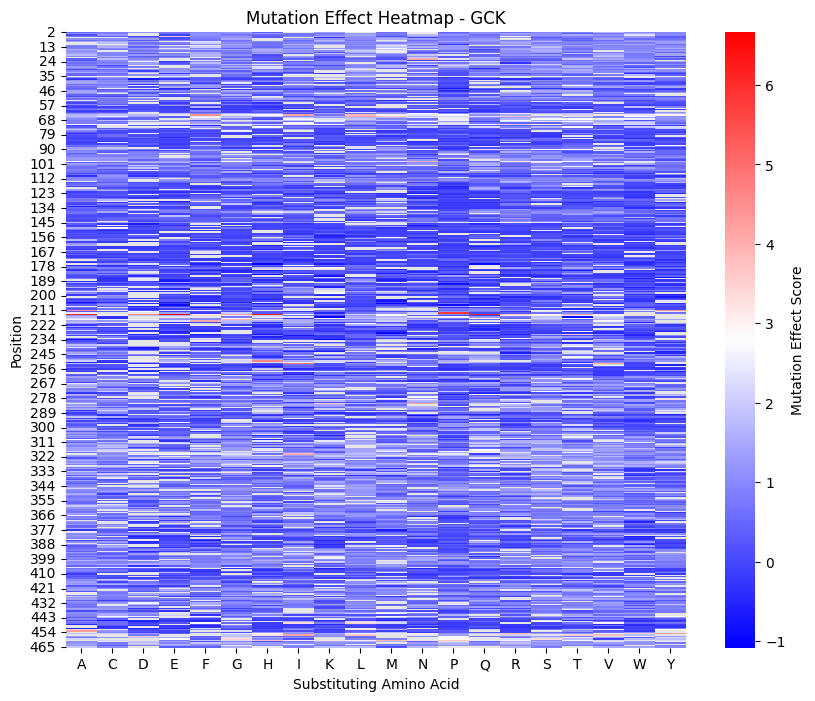

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

seed = 0
df1 = pd.read_csv(f"GCK/test.seed.{seed}.csv")
df2 = pd.read_csv(f"GCK/train.seed.{seed}.csv")

df = pd.concat([df1, df2])
print(df.shape)

# Create a pivot table for the heatmap
heatmap_data = df.pivot_table(index='pos', columns='alt', values='score.1', aggfunc='mean')

# Create a full matrix with NaN for missing substitutions
all_aa = list("ACDEFGHIKLMNPQRSTVWY")  # All 20 amino acids
heatmap_data = heatmap_data.reindex(index=sorted(df['pos'].unique()), columns=all_aa)

# Define the custom color scale
cmap = LinearSegmentedColormap.from_list("blue_white_red", ['blue', 'white', 'red'])

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data, cmap=cmap,
    mask=heatmap_data.isnull(),  # Mask NaN values
    cbar_kws={'label': 'Mutation Effect Score'}
)

# Set NaN values to very light grey
plt.gca().patch.set_color((0.9, 0.9, 0.9))

plt.title('Mutation Effect Heatmap - GCK')
plt.xlabel('Substituting Amino Acid')
plt.ylabel('Position')
plt.show()


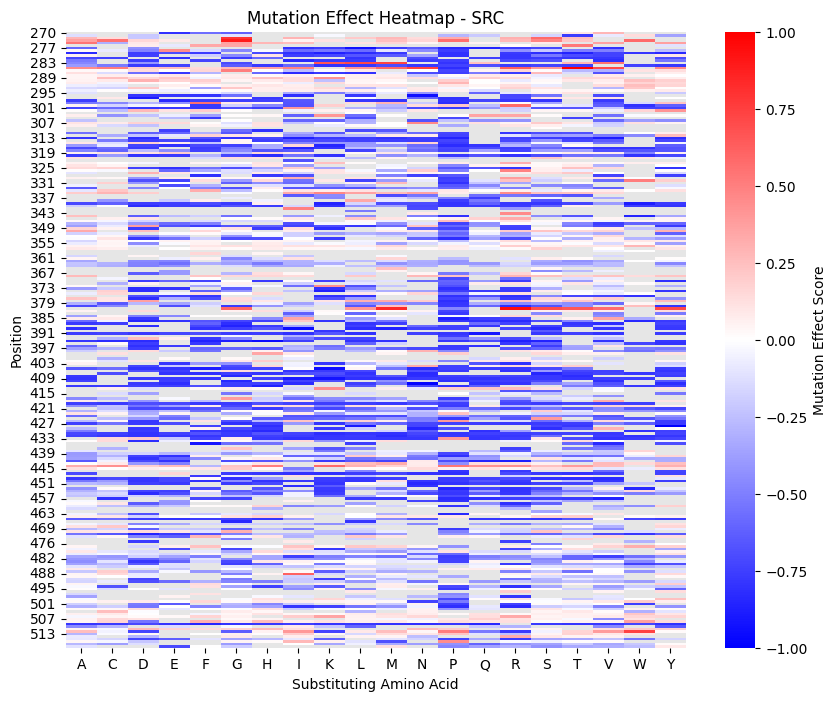

In [ ]:
# Heatmap of Src scores
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


df = pd.read_csv("SRC_test_df_withscore_uniprot_with_ANC.csv")
# Extract wildtype AA, position, and substituted AA
df['wildtype_aa'] = df['mutation'].str[2]  # Extract wildtype amino acid
df['position'] = df['mutation'].str[3:-1].astype(int)  # Extract position
df['sub_aa'] = df['mutation'].str[-1]  # Extract substituted amino acid


# Create a pivot table for the heatmap
heatmap_data = df.pivot_table(index='position', columns='sub_aa', values='score', aggfunc='mean')

# Create a full matrix with NaN for missing substitutions
all_aa = list("ACDEFGHIKLMNPQRSTVWY")  # All 20 amino acids
heatmap_data = heatmap_data.reindex(index=sorted(df['position'].unique()), columns=all_aa)

# Define the custom color scale
cmap = LinearSegmentedColormap.from_list("blue_white_red", ['blue', 'white', 'red'])

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data, cmap=cmap,
    vmin=-1, vmax=1, mask=heatmap_data.isnull(),  # Mask NaN values
    cbar_kws={'label': 'Mutation Effect Score'}
)

# Set NaN values to grey
plt.gca().patch.set_color((0.9, 0.9, 0.9))


plt.title('Mutation Effect Heatmap - SRC')
plt.xlabel('Substituting Amino Acid')
plt.ylabel('Position')
plt.show()